In [56]:
import sys
sys.path.append('/Users/haipeng/Documents/GitHub/SWIT-1.0/toolbox/')

In [57]:
%pylab inline

import matplotlib
#matplotlib.rcParams["qtagg"] 

import matplotlib.pyplot as plt
import numpy as np

# my lib
import base
from solver import source_wavelet

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [58]:
from scipy import fftpack
from scipy.signal import hilbert


def cross_correlate_max(obs_data, syn_data):
    ''' calculate the cross-correlation lag between two traces
    '''

    nt = np.size(obs_data, -1)

    a =   fftpack.fft(obs_data)
    b = - fftpack.fft(syn_data).conjugate()

    cc = np.argmax(np.abs(fftpack.ifft(a*b)), -1) - 1

    if cc < nt//2:
        cc = cc + nt

    return cc


def misfit_traveltime(obs_trace, syn_trace, nt, dt):
    ''' Cross correlation traveltime (Luo & Schuster, 1991; Tromp et al., 2005)
    '''

    rsd = np.zeros(1)

    # compute the cross-correlation in an awkward paralle scheme
    ccmax =  cross_correlate_max(obs_trace, syn_trace)

    obs_norm = np.linalg.norm(obs_trace, ord=2)
    syn_norm = np.linalg.norm(syn_trace, ord=2)

    adj_trace = np.zeros(nt)
    adj_trace[1:-1] = (syn_trace[2:] - syn_trace[0:-2])/(2.*dt)

    if obs_norm > 0. and syn_norm > 0. and np.sum(abs(adj_trace)) > 0.:
        rsd += 0.5 * np.power(ccmax-nt+1, 2)*dt

    return rsd


def misfit_waveform(obs_trace, syn_trace, nt, dt):
    ''' Waveform difference L2-norm (Tarantola, 1984)
    '''
    # parameters
    rsd = np.zeros(1)

    obs_norm = np.linalg.norm(obs_trace, ord=2)
    syn_norm = np.linalg.norm(syn_trace, ord=2)

    rsd_trace = np.zeros(nt)

    if obs_norm > 0. and syn_norm > 0.:
        rsd_trace = syn_trace - obs_trace
        rsd += np.sqrt(np.sum(rsd_trace*rsd_trace*dt))

    return rsd


def misfit_global_correlation(obs_trace, syn_trace, nt, dt):
    ''' Normalized global-correlation coefficient (Choi & Alkhalifah, 2012)
    '''
    # get parameters
    rsd = np.zeros(1)

    obs_norm = np.linalg.norm(obs_trace, ord=2)
    syn_norm = np.linalg.norm(syn_trace, ord=2)
    if obs_norm > 0. and syn_norm > 0.:
        obs_trace_norm = obs_trace/obs_norm
        syn_trace_norm = syn_trace/syn_norm
        rsd += - np.corrcoef(syn_trace_norm, obs_trace_norm)[0,1]

    return rsd

In [59]:
nt = 2000
nt0 = 500
dt = 0.001
f0 = 10
wavelet = source_wavelet(nt0, dt, f0, 'ricker')

In [137]:
obs_trace = np.zeros(nt)
obs_trace[nt//2 - nt0//2 : nt//2 + nt0//2] = wavelet
obs_trace[nt//2 + nt0//2 : nt//2 + 3*nt0//2] = wavelet * 0.3

misfit1 = np.zeros(nt-nt0)
misfit2 = np.zeros(nt-nt0)
misfit3 = np.zeros(nt-nt0)
misfit4 = np.zeros(nt-nt0)
misfit5 = np.zeros(nt-nt0)

for shift in range(0, nt-nt0):
    syn_trace = np.zeros(nt)
    syn_trace[shift:shift + nt0] = wavelet
    misfit1[shift] = misfit_waveform(obs_trace, syn_trace, nt, dt)
    misfit2[shift] = misfit_global_correlation(obs_trace, syn_trace, nt, dt)
    misfit3[shift] = misfit_traveltime(obs_trace, syn_trace, nt, dt)

misfit1 /= misfit1.max()
misfit2 /= abs(misfit2).max(); misfit2 +=1
misfit3 /= misfit3.max()

misfit4 = misfit1 + misfit3
misfit5 = misfit2 * misfit3*misfit1
misfit4 /= misfit4.max()
misfit5 /= misfit5.max()

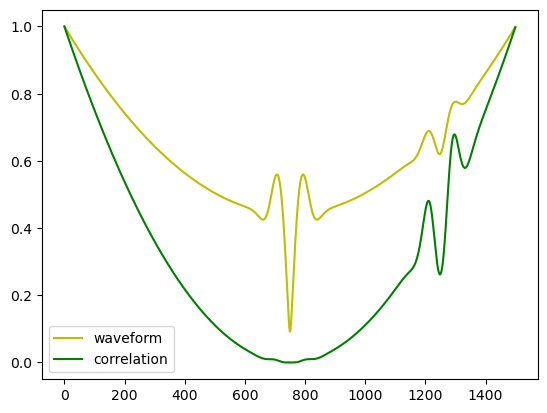

In [138]:
plt.figure()
# plt.plot(np.exp(misfit1), '-r')
# plt.plot(misfit2, '-b')
# plt.plot(misfit3, '-k')
plt.plot(misfit4, '-y')
plt.plot(misfit5, '-g')
plt.legend(['waveform', 'correlation', 'travetime', '1+3', '2+3'])
plt.show()

In [90]:
obs_trace.shape

(2000,)